COMP4423 – Computer Vision

Group Project: Fashion Image Generation

Group 1

JIANG Yiyang (21095707d)  
YE Haowen (21098829d)  
ZHANG Wengyu (21098431d)  

April 2023

---

### This is the **cDCGAN model training and validation program** for the Project

<font color='red' size='5'> Please carefully read User_Manual.pdf file first before running </font>

Conditional Deep Convolutional GAN (cDCGAN)  
Reference:
- https://www.kaggle.com/code/tapliershiru/fashion-mnist-cgans-with-pytorch-tensorboard
- https://doi.org/10.48550/arXiv.1511.06434 [DCGAN paper PDF]

In [1]:
# -*- coding: utf-8 -*-
from torchvision import transforms
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from PIL import Image
from collections import Counter
from sklearn.manifold import TSNE
from time import time
from datetime import datetime
import copy
import seaborn as sns
import cv2

torch.__version__

torch.manual_seed(42)

trainPath = '../fashion-mnist/train.csv' # Path of data
testPath = '../fashion-mnist/test.csv' # Path of data

labelMap = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

batch_size = 64

learning_rate = 0.0002

# Set proper device according to your machine!
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
# device = torch.device('mps') # use 'mps' if your Mac has Apple Silicon MPS GPU acceleration
print(device)

cuda


In [2]:
class Sample:
    def __init__(self, idx=0, img=None, feat = None, label=None):
        self.idx = idx
        self.img = img
        self.feat = feat
        self.label = label
        
def loadImage(inPath):
    samples = []
    dataCsv = pd.read_csv(inPath)
    dataCsvImg = dataCsv.drop(columns = 'label')
    dataCsvImg = dataCsvImg.values.astype('uint8')
    
    images = dataCsvImg.reshape(-1, 28, 28)
    labels = dataCsv['label'].values
    
    for i in range (len(images)):
        sample = Sample(idx=i, img=images[i], feat = dataCsvImg[i], label=labels[i])
        samples.append(sample)
    return samples, images, labels

trainSamples, trainImages, trainLabels = loadImage(trainPath)
testSamples, testImages, testLabels = loadImage(testPath)

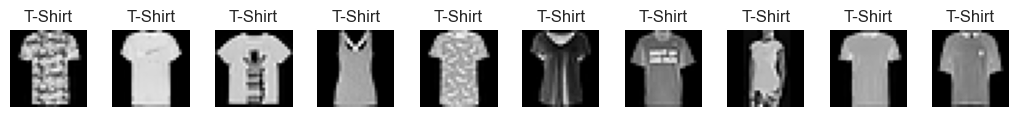

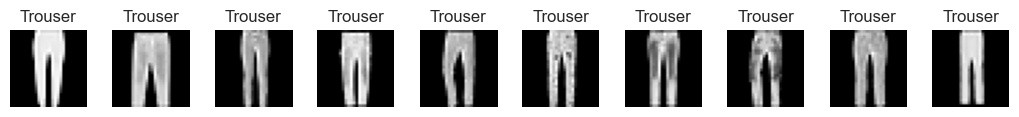

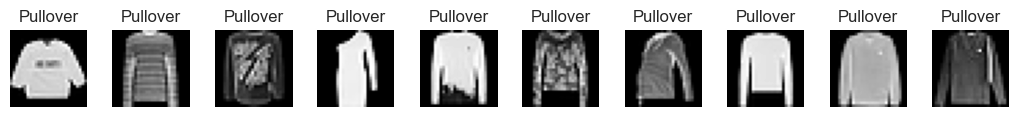

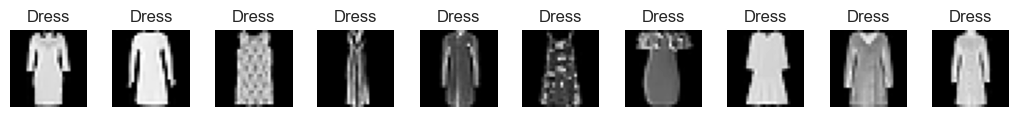

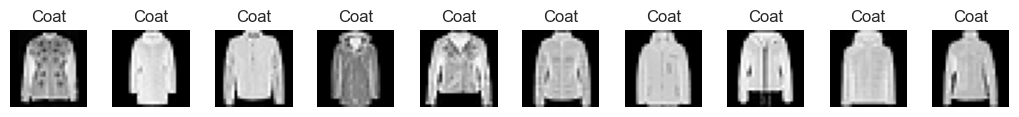

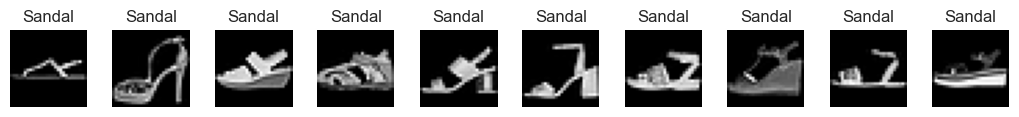

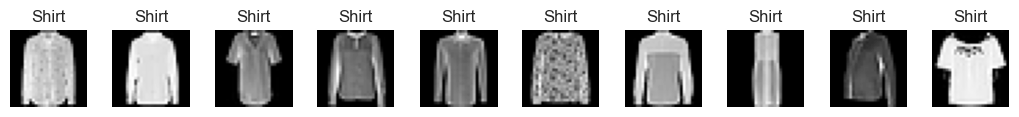

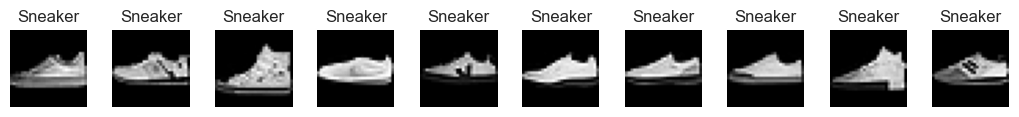

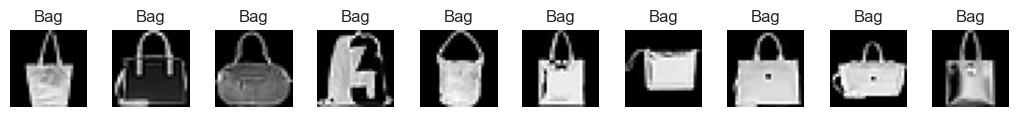

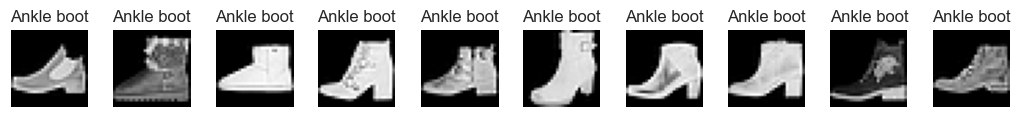

In [21]:
# Task 1: Preprocess the fashion image dataset and visualize some example images.
for l in range(10):
    count = 0
    for sample in trainSamples:
        if int(sample.label) == l:
            if count%10 == 0:
                plt.figure(figsize=(13, 1))
            plt.subplot(1, 10, count%10+1)
            plt.title(labelMap[int(l)])
            plt.axis('off')
            plt.imshow(sample.img, cmap ='gray')
            count += 1
            if (count >= 10):
                break

In [3]:
# You need to implement this by yourself
class FashionDataset(Dataset):
    def __init__(self, inImages, inLabels, transform=None):
        self.transform = transform
        self.images = inImages
        self.labels = inLabels
       
    def __len__(self):
       return len(self.images)
    
    def __getitem__(self, idx):
        img = self.transform(Image.fromarray(self.images[idx]))
        label = self.labels[idx]
        return img, label

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])
train = FashionDataset(trainImages, trainLabels, transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = FashionDataset(testImages, testLabels, transform = transform)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [4]:
randomChannelSize = 16
randomGenerateLength = 7 # 7*7 -> 14*14 -> 28*28

class generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_layer = nn.Sequential(
            nn.Embedding(10, 10),
            nn.Linear(10, randomGenerateLength * randomGenerateLength)
        )
        
        self.random_layer = nn.Sequential(
            nn.Linear(100, randomChannelSize*randomGenerateLength*randomGenerateLength),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(randomChannelSize+1, randomChannelSize, kernel_size=4, stride=2, padding=1), # 7*7 -> 14*14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.ConvTranspose2d(randomChannelSize, randomChannelSize, kernel_size=4, stride=2, padding=1), # 14*14 -> 28*28
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
                        
            nn.Conv2d(randomChannelSize, 1, kernel_size=7, padding=3), # Channel -> 1
            
            nn.Tanh()
        )

    def forward(self, X, labels):
        X = self.random_layer(X).view(X.shape[0], randomChannelSize, randomGenerateLength, randomGenerateLength)
        L = self.label_layer(labels).view(X.shape[0], 1, randomGenerateLength, randomGenerateLength)
        
        X = torch.cat([X, L], dim = 1)
        
        X = self.model(X)

        return X

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_layer = nn.Sequential(
            nn.Embedding(10, 10),
            nn.Linear(10, 28*28)
        )
        
        self.model = nn.Sequential(
            nn.Conv2d(1+1, randomChannelSize, kernel_size=3, stride=2, padding=1), # 28*28 -> 14*14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(randomChannelSize, 2*randomChannelSize, kernel_size=3, stride=2, padding=1), # 14*14 -> 7*7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            
            nn.Linear(2*randomChannelSize*7*7, 1)
        )
    
    def forward(self, X, labels):
        L = self.label_layer(labels).view(X.shape[0], 1, 28, 28) 
        X = torch.cat([X, L], dim = 1)
        X = self.model(X)
        return X

In [6]:
G = generator()
G.to(device)

D = discriminator()
D.to(device)

G_optimizer = optim.Adam(G.parameters(), lr = learning_rate)
D_optimizer = optim.Adam(D.parameters(), lr = learning_rate)

criterion = nn.BCEWithLogitsLoss() # combine sigmoid with and BCELoss

EPOCH 010 finalized: discriminator loss 0.001316 - gererator loss 0.000907, time 377.863859s


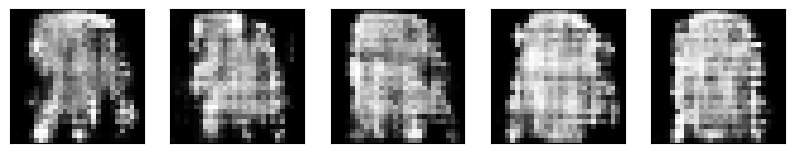

EPOCH 020 finalized: discriminator loss 0.001126 - gererator loss 0.000912, time 760.747559s


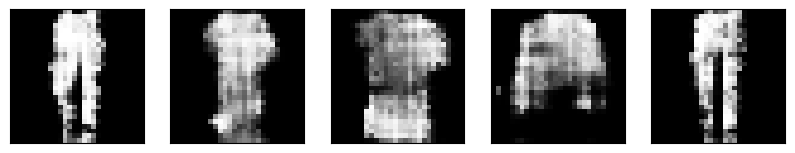

EPOCH 030 finalized: discriminator loss 0.001245 - gererator loss 0.001055, time 1151.238084s


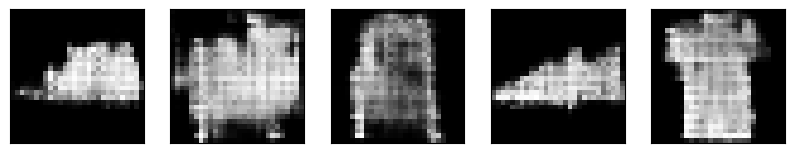

EPOCH 040 finalized: discriminator loss 0.001332 - gererator loss 0.001273, time 1537.050346s


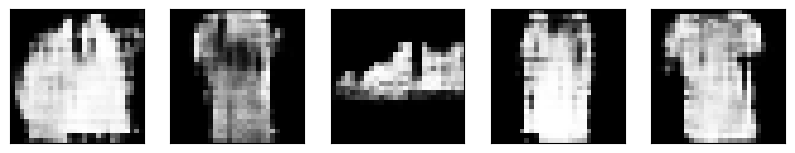

EPOCH 050 finalized: discriminator loss 0.001218 - gererator loss 0.001274, time 1908.223505s


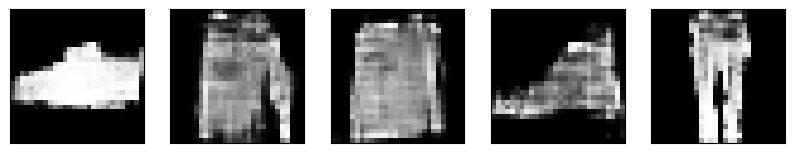

EPOCH 060 finalized: discriminator loss 0.001205 - gererator loss 0.001260, time 2286.916252s


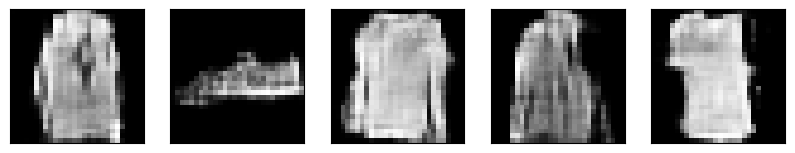

EPOCH 070 finalized: discriminator loss 0.001304 - gererator loss 0.001497, time 2666.363973s


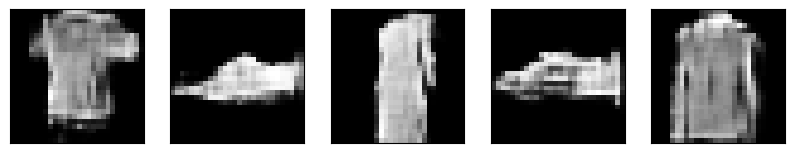

EPOCH 080 finalized: discriminator loss 0.001056 - gererator loss 0.001229, time 3047.910428s


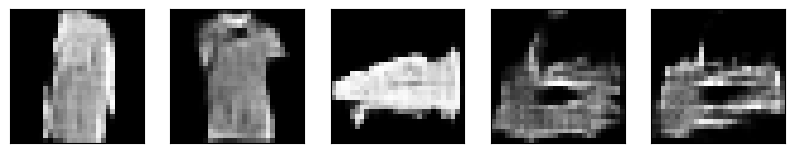

EPOCH 090 finalized: discriminator loss 0.001260 - gererator loss 0.001449, time 3435.609080s


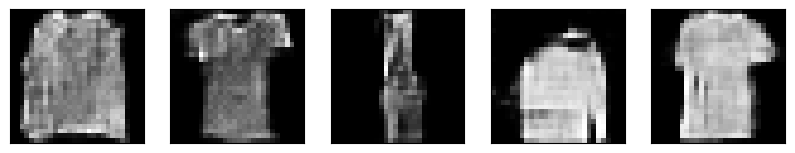

EPOCH 100 finalized: discriminator loss 0.001221 - gererator loss 0.001488, time 3814.463256s


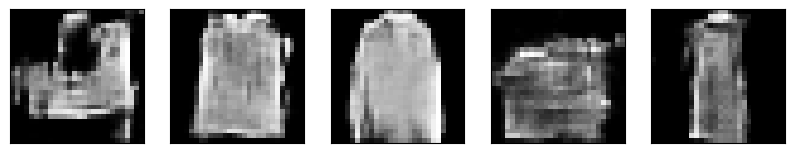

Model saved to cDCGAN2_G_16_100.pth
EPOCH 110 finalized: discriminator loss 0.001243 - gererator loss 0.001390, time 4202.674746s


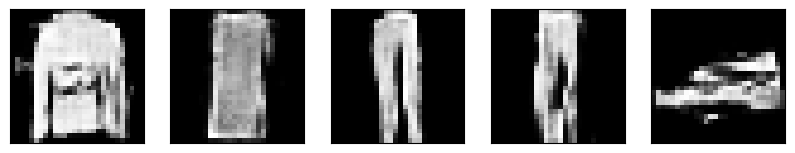

EPOCH 120 finalized: discriminator loss 0.001109 - gererator loss 0.001686, time 4592.399914s


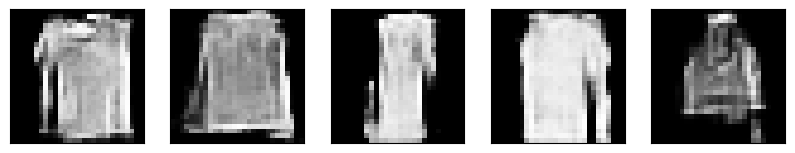

EPOCH 130 finalized: discriminator loss 0.001052 - gererator loss 0.001452, time 4990.569671s


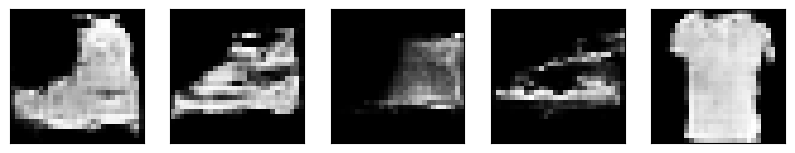

EPOCH 140 finalized: discriminator loss 0.000872 - gererator loss 0.001712, time 5394.169549s


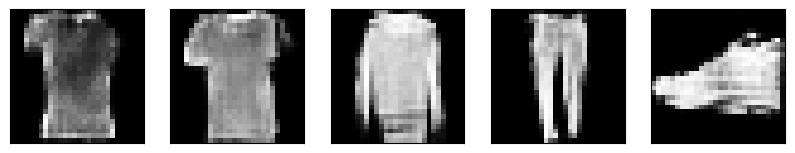

EPOCH 150 finalized: discriminator loss 0.001521 - gererator loss 0.001418, time 5771.753443s


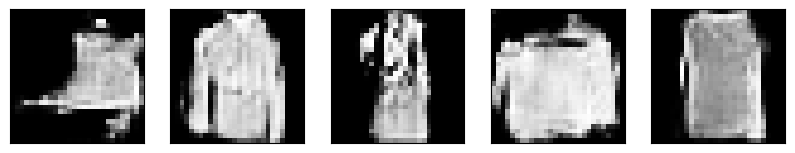

EPOCH 160 finalized: discriminator loss 0.001005 - gererator loss 0.001425, time 6143.237408s


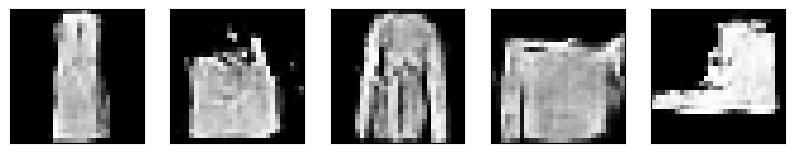

EPOCH 170 finalized: discriminator loss 0.001038 - gererator loss 0.001452, time 6513.923542s


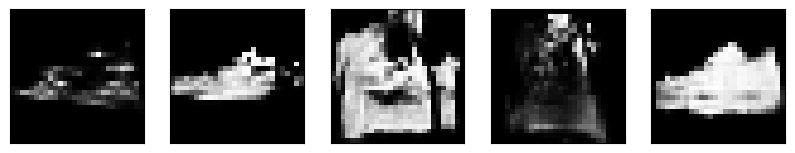

EPOCH 180 finalized: discriminator loss 0.001083 - gererator loss 0.001254, time 6890.217240s


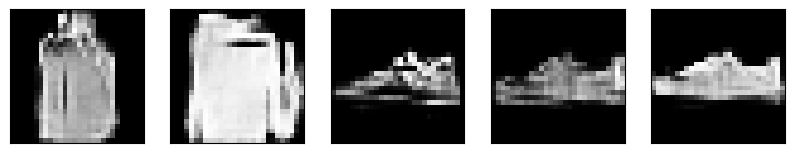

EPOCH 190 finalized: discriminator loss 0.001273 - gererator loss 0.001687, time 7259.271369s


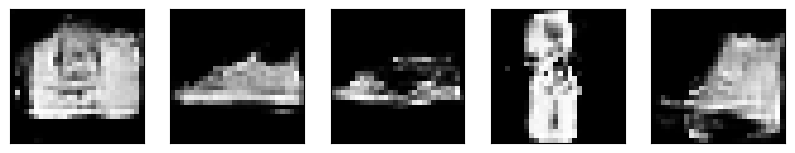

EPOCH 200 finalized: discriminator loss 0.000951 - gererator loss 0.001587, time 7630.576534s


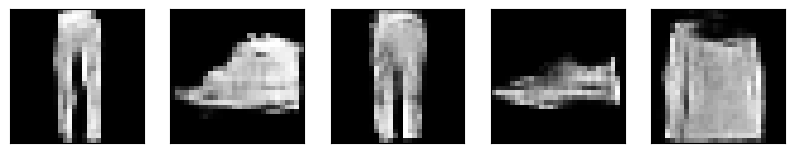

Model saved to cDCGAN2_G_16_200.pth
EPOCH 210 finalized: discriminator loss 0.001100 - gererator loss 0.001449, time 8002.799837s


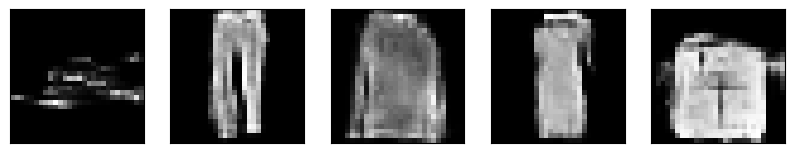

EPOCH 220 finalized: discriminator loss 0.001231 - gererator loss 0.001626, time 8373.296113s


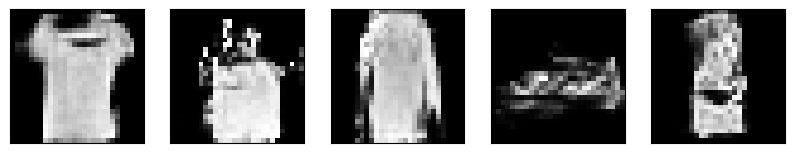

EPOCH 230 finalized: discriminator loss 0.001021 - gererator loss 0.001518, time 8746.435092s


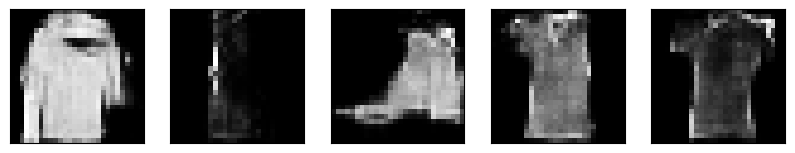

EPOCH 240 finalized: discriminator loss 0.001006 - gererator loss 0.001672, time 9118.868268s


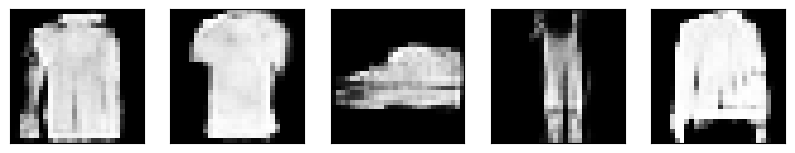

EPOCH 250 finalized: discriminator loss 0.000955 - gererator loss 0.001510, time 9492.662879s


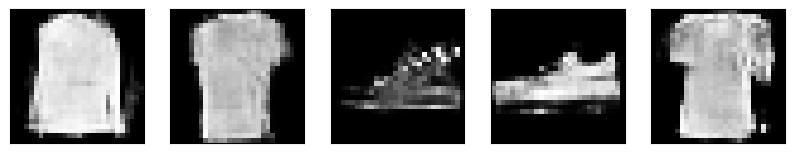

EPOCH 260 finalized: discriminator loss 0.000885 - gererator loss 0.001550, time 9868.581927s


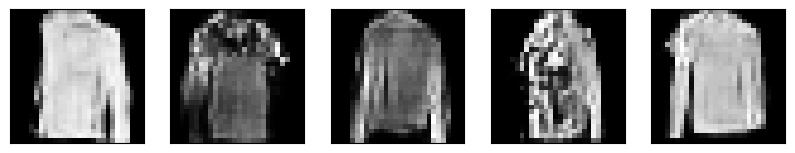

EPOCH 270 finalized: discriminator loss 0.000991 - gererator loss 0.001430, time 10241.751804s


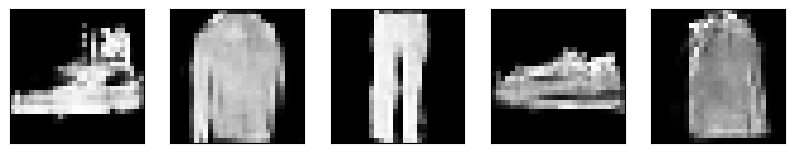

EPOCH 280 finalized: discriminator loss 0.001063 - gererator loss 0.001293, time 10622.919090s


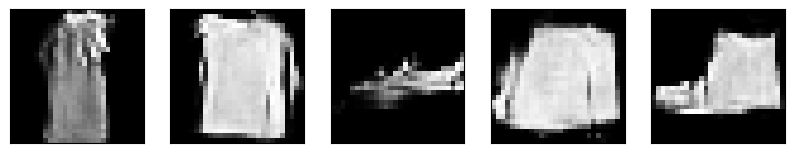

EPOCH 290 finalized: discriminator loss 0.001131 - gererator loss 0.001484, time 11008.987307s


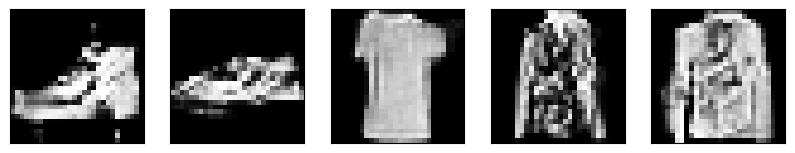

EPOCH 300 finalized: discriminator loss 0.001031 - gererator loss 0.001584, time 11389.940409s


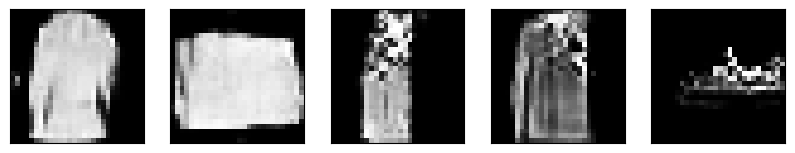

Model saved to cDCGAN2_G_16_300.pth


In [89]:
EPOCH = 300
gLoss = dict()
dLoss = dict()
startTime = datetime.now()
for epoch in range(EPOCH):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (images_real, labels_real) in enumerate(train_loader):
        batch_size = images_real.size(0)
        images_real = images_real.to(device)
        labels_real = labels_real.to(device)

        # Train The Generator
        G_optimizer.zero_grad()
        
        random = torch.randn(batch_size, 100).to(device)
        
        random_labels = torch.randint(low=0, high=10, size=(batch_size,), device=device)
        
        images_false = G.forward(random, random_labels)
        output_false = D.forward(images_false, random_labels)
        
        labels_false = torch.ones(batch_size).to(device)
        G_loss = criterion(output_false.view(*labels_false.shape), labels_false)
        G_loss.backward()
        G_optimizer.step()

        # Train The Discriminator
        D_optimizer.zero_grad()
        
        # real images
        outputs_real = D.forward(images_real, labels_real)
        labels_real_false = (torch.ones(batch_size)).to(device)
        D_loss_real = criterion(outputs_real.view(*labels_real_false.shape), labels_real_false)

        # false images
        random = torch.randn(batch_size, 100).to(device)
        random_labels = torch.randint(low=0, high=10, size=(batch_size,), device=device)
        
        images_false = G.forward(random, random_labels)
        outputs_false = D.forward(images_false, random_labels)
        
        labels_false = torch.zeros(batch_size).to(device)
        D_loss_false = criterion(outputs_false.view(*labels_false.shape), labels_false)

        D_loss = D_loss_real + D_loss_false
        D_loss.backward()
        D_optimizer.step()

        D_running_loss += D_loss.item()
        G_running_loss += G_loss.item()
        
        D_running_loss /= len(train_loader)
        G_running_loss /= len(train_loader)
        
        gLoss[epoch] = G_running_loss
        dLoss[epoch] = D_running_loss
  
    if (epoch + 1) % 10 == 0:
        endTime = datetime.now()
        duration = (endTime - startTime).total_seconds()
        # print the loss after each epoch
        print('EPOCH {:03d} finalized: discriminator loss {:03.6f} - gererator loss {:03.6f}, time {:03.6f}s'.format(epoch + 1, D_running_loss, G_running_loss, duration))

        # display 10 generated images
        random = torch.randn(10, 100).to(device)
        random_labels = np.array([i for _ in range(1) for i in range(10)])
        random_labels = torch.from_numpy(random_labels).int().to(device)
        output  = G.forward(random, random_labels).unsqueeze(1).data.to(device)
        output = output.view(10, 1, 28, 28)
        grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(grid)
        plt.show()
        
    if (epoch == 100):
        savePath = 'cDCGAN2_G_16_100.pth'
        torch.save(G, savePath)
        print('Model saved to {}'.format(savePath))
    elif (epoch == 200):
        savePath = 'cDCGAN2_G_16_200.pth'
        torch.save(G, savePath)
        print('Model saved to {}'.format(savePath))

savePath = 'cDCGAN2_G_16_300.pth'
torch.save(G, savePath)
print('Model saved to {}'.format(savePath))

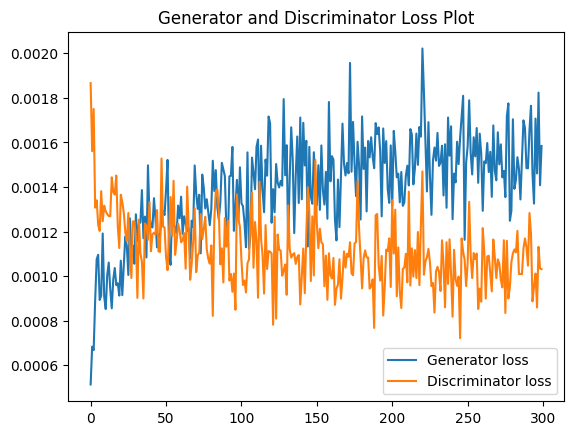

In [90]:
plt.title("Generator and Discriminator Loss Plot")
plt.plot(gLoss.keys(),gLoss.values(), label="Generator loss")
plt.plot(dLoss.keys(),dLoss.values(), label="Discriminator loss")
plt.legend()
plt.show()

./cDCGAN_saved_models/cDCGAN2_G_16_300.pth


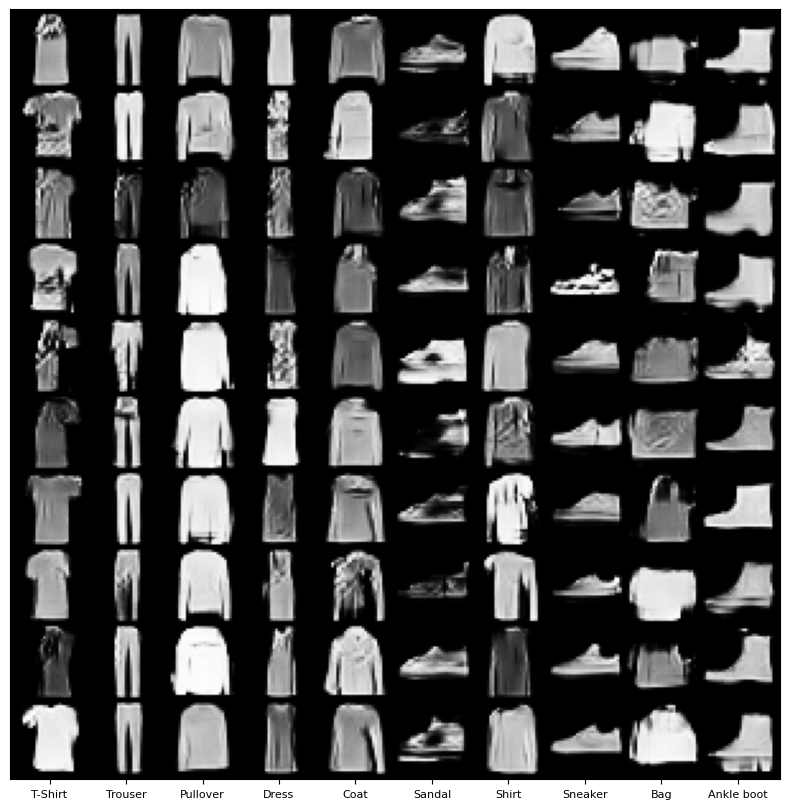

In [5]:
# Test on the trained model
# loadPath = savePath
loadPath = './cDCGAN_saved_models/cDCGAN2_G_16_300.pth'
print(loadPath)
device = torch.device('cpu')
G = torch.load(loadPath,map_location=device)

random = torch.randn(100, 100).to(device)

random_labels = np.array([i for _ in range(10) for i in range(10)])
random_labels = torch.from_numpy(random_labels).int().to(device)

G.eval()
output  = G.forward(random, random_labels).detach().unsqueeze(1).data

output = output.view(100, 1, 28, 28)

grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid)
plt.yticks([])
plt.xticks(np.arange(15, 300, 30), labelMap, fontsize=8)
plt.show()


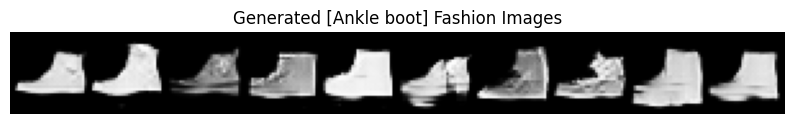

In [6]:
# generate N images from a label
def generateFromLabel(inG, inLabel, inNum):
    random = torch.randn(inNum, 100).to(device)
    random_labels = np.array([i for _ in range(1) for i in [inLabel]*inNum])
    random_labels = torch.from_numpy(random_labels).int().to(device)
    output  = inG.forward(random, random_labels).unsqueeze(1).data.to(device)
    output = output.view(inNum, 1, 28, 28)
    grid = make_grid(output, nrow=inNum, normalize=True).permute(1,2,0).cpu().numpy()
    return grid

l = 9
n = 10
fig, ax = plt.subplots(figsize=(n,n))
img = generateFromLabel(G, l, n)
ax.imshow(img)
plt.title('Generated ['+labelMap[l]+'] Fashion Images')
plt.axis('off')
plt.show()

/var/folders/9c/91xx8kds77sbfz7jywfpsgnc0000gn/T/ipykernel_78826/2791474368.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 10, i+1)


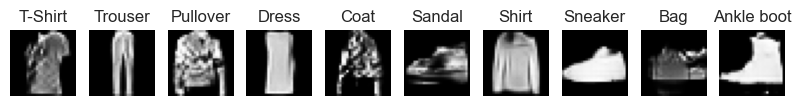

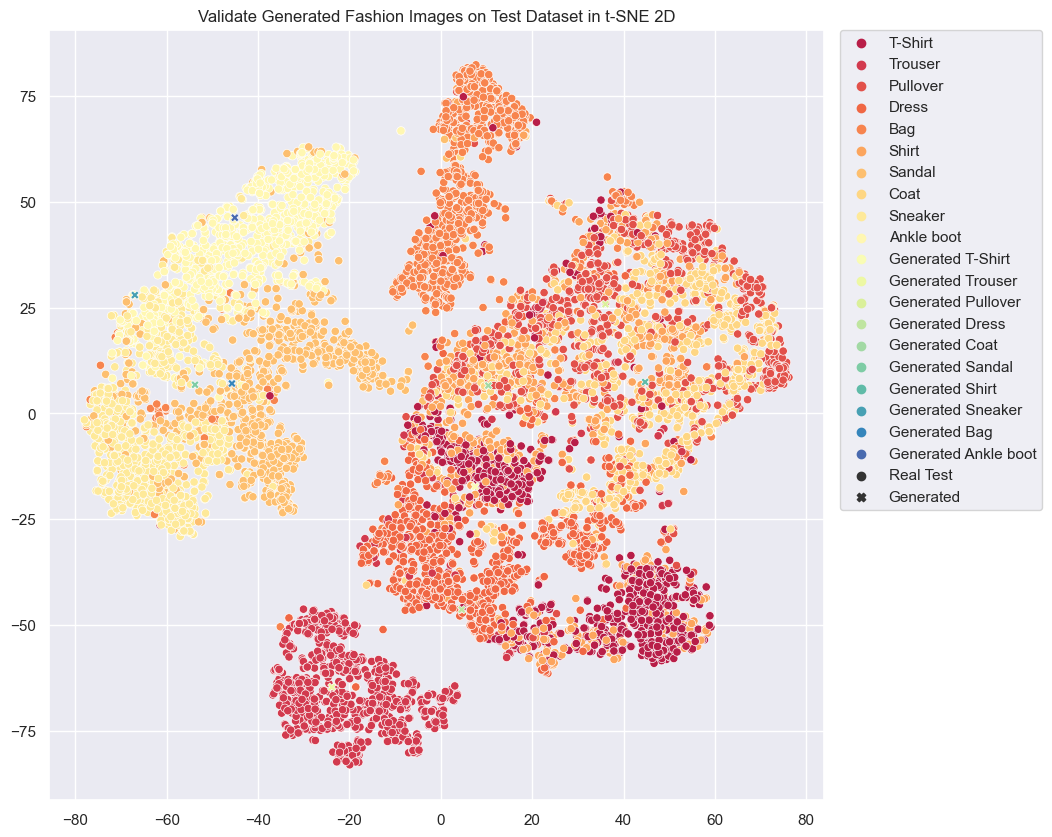

In [20]:
# Validate generated images on test dataset in t-SNE 2D
testlabelMap = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 
                'Generated T-Shirt', 'Generated Trouser', 'Generated Pullover', 'Generated Dress', 'Generated Coat', 'Generated Sandal', 'Generated Shirt', 'Generated Sneaker', 'Generated Bag', 'Generated Ankle boot']

sns.set(rc={'figure.figsize':(10,10)}) 
palette = sns.color_palette("Spectral", 20) 

isTest = ['Real Test' for sample in testSamples]

test = testSamples
fig, ax = plt.subplots(figsize=(10,10))
for i in range(10):
    genImage = generateFromLabel(G, i, 1)
    genImage = cv2.normalize(src=genImage, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    plt.subplot(1, 10, i+1)
    plt.title(labelMap[i])
    plt.axis('off')
    plt.imshow(genImage, cmap ='gray')
    
    genSample = Sample(img=genImage, feat = genImage[:,:,0].reshape(28*28), label=10+i)
    test = test+[genSample]
    isTest.append('Generated')
plt.axis('off')
plt.show()

featuresTest = np.array([sample.feat for sample in test])
labelsTest = [testlabelMap[sample.label] for sample in test]

tsne = TSNE()
XEmbeddedTest = tsne.fit_transform(featuresTest)
_ = sns.scatterplot(x=XEmbeddedTest[:,0], y=XEmbeddedTest[:,1], hue=labelsTest, style=isTest, legend='full', palette=palette).set(title='Validate Generated Fashion Images on Test Dataset in t-SNE 2D')
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
